## imports and setup

In [3]:
import numpy as np
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True) ## otherwise stiff ODE solver fails
import pandas as pd
from scipy.optimize import fsolve   
from cycler import cycler
from matplotlib import rc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.lines as mlines
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use(['science'])
rc('font', **{'family': 'serif', 'serif': ['cmr10'], 'size': 10})
rc('figure.constrained_layout', use=True)
rc('text', usetex=True)
rc('lines', linewidth=2)
rc('axes.formatter', use_mathtext=True)
plt.rcParams.update({'figure.dpi': '100'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors.append('tab:pink')
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

comp_cycler = (cycler(color=colors[:3]) + cycler(lw=[2, 2, 2]) + cycler(linestyle=['-', '--', '-.']))

## Bifurcation Diagrams

In [4]:
def add_arrow(line, i, ho, vo, size=15, color='k', length_fraction=0.5):
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    start_ind = int(len(xdata) * length_fraction)
    end_ind = start_ind + 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color, lw=line.get_linewidth()),
        size=size,
    )
    line.axes.text(xdata[end_ind] + ho, ydata[end_ind] + vo, i, ha='center', va='center')

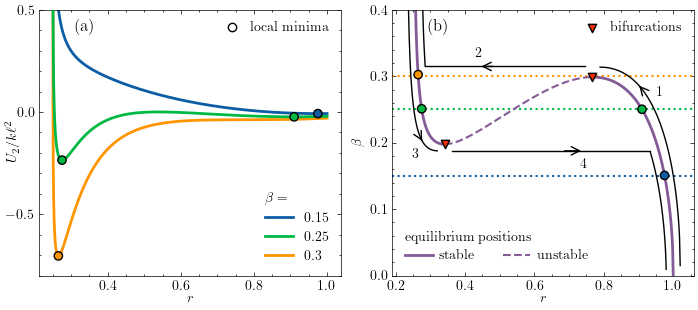

In [5]:
eps = 0.75

def U(x, h):
    return -h**2/x**3/3 - 0.5*eps**2*np.log(1-(1 - x)**2/eps**2)

def F(x, h):
    return -h**2/x**4 + (1 - x)/(1 - (1 - x)**2/eps**2)

def h_eq(x, eps=0.75):
    return np.sqrt(x**4 * (1 - x)/(1 - (1 - x)**2/eps**2))

beta_vals = np.array([0.15, 0.25, 0.3])
x_vals = np.linspace(1 - eps + 1e-7, 1 - 1e-10, 2000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))


U_vals = U(x_vals[:, None], np.array(beta_vals)[None, :])
potentials = ax1.plot(x_vals, U_vals, label=[fr"${h_val}$" for h_val in beta_vals], zorder=1)
potentials[1].set_zorder(3)
legend1 = ax1.legend(frameon=False, title=r" $\beta = $", loc=4, alignment='left')

[ax2.axhline(h_val, linestyle=':', color=f'C{i}', linewidth=1.5)for i, h_val in enumerate(beta_vals)]


beta_cont_vals = h_eq(x_vals)
h_diff = np.diff(beta_cont_vals, append=0)
mask1 = np.logical_and(x_vals < 1-0.5*eps, h_diff < 0)
mask2 = h_diff >= 0
mask3 = np.logical_and(x_vals > 1-0.5*eps, h_diff < 0)
c_line = 'C4'
c_marker = 'C3'
p = 5
stable, = ax2.plot(x_vals[mask1][::p], beta_cont_vals[mask1][::p], c=c_line, label='stable')
unstable, = ax2.plot(x_vals[mask2][::p], beta_cont_vals[mask2][::p], linestyle='--', linewidth=1.5, c=c_line, label='unstable')
ax2.plot(x_vals[mask3][::-p], beta_cont_vals[mask3][::-p], c=c_line)

b_det, b_col = beta_cont_vals[mask2][np.array([0, -1])]
x_det, x_col = x_vals[mask2][np.array([0, -1])]
bifurks = ax2.scatter([x_det, x_col], [b_det, b_col], c='C3', marker='v', edgecolor='k', zorder=5, label="bifurcations")
i_end_col = np.argmin(np.abs(beta_cont_vals[mask1] - b_col))
i_end_det = np.argmin(np.abs(beta_cont_vals[mask3] - b_det))

a1, = ax2.plot(x_vals[mask3][:4:-p] + 0.02, beta_cont_vals[mask3][:4:-p] + 0.015, c='k', lw=1)
x_range = np.linspace(x_col - 0.02, x_vals[mask1][i_end_col] + 0.02, 10)
b_val = np.full(10, b_col + 0.016)
a2, = ax2.plot(x_range, b_val, c='k', lw=1)
a2b, = ax2.plot(x_vals[mask1][:i_end_col+1:] + 0.02, beta_cont_vals[mask1][:i_end_col+1:] + 0.016, c='k', lw=1)
a3, = ax2.plot(x_vals[mask1][::p] - 0.02, beta_cont_vals[mask1][::p] - 0.01, c='k', lw=1)
x_range = np.linspace(x_det + 0.02, x_vals[mask3][i_end_det] - 0.02, 10)
b_val = np.full(10, b_det - 0.01)
a4, = ax2.plot(x_range, b_val, c='k', lw=1)
a4b, = ax2.plot(x_vals[mask3][-2:i_end_det+1:-1] - 0.02, beta_cont_vals[mask3][-2:i_end_det+1:-1] -0.01, c='k', lw=1)
for i, a, ha, va in [("1", a1, 0.06, -0.01), ("2", a2, 0, 0.02), 
                     ("3", a3, -0.02, -0.02), ("4", a4, 0, -0.02)]:
    add_arrow(a, i, ha, va)



i_eq = np.array([np.argmax(beta_cont_vals < beta_vals.squeeze()[0]),
                np.argmax(beta_cont_vals < beta_vals.squeeze()[1]),
                np.argmax(np.logical_and(beta_cont_vals < beta_vals.squeeze()[1], x_vals > 1-0.5*eps)),
                np.argmax(beta_cont_vals < beta_vals.squeeze()[2])])
                 
c = ['C0', 'C1', 'C1', 'C2']
ax2.scatter(x_vals[i_eq-1], beta_cont_vals.squeeze()[i_eq-1], c=c, marker='o', zorder=5, edgecolor='k')
ax1.scatter(x_vals[i_eq-1], U_vals[i_eq-1, np.array([0,1,1,2])], c=c, marker='o', zorder=5, edgecolor='k')

ax1.set_ybound(-0.8, 0.5)
ax1.set_yticks(np.linspace(-0.5, 0.5, 3))
ax1.set_ylabel(r"$U_2/k\ell^2$", labelpad=-10)

legend2 = ax1.legend(handles=[mlines.Line2D([], [], mec='k', mfc='w', marker='o', linestyle='None', label=r"local minima")], loc=1, frameon=False, handlelength=1, alignment='left')
ax1.add_artist(legend1)

ax2.set_ylabel(r"$\beta$")
ax2.set_ybound(0, 0.4)  
# ax2.set_xbound(1-eps, 1) 
ax2.set_yticks(np.linspace(0, 0.4, 5))
legend3 = ax2.legend(loc=3, title="equilibrium positions", handles=[stable, unstable], ncols=2, handletextpad=0.5, frameon=False, alignment='left')
ax2.legend(loc=1, handles=[bifurks], frameon=False, handlelength=1, alignment='left')
ax2.add_artist(legend3)


for i, axi in enumerate((ax1, ax2)):
    c = chr(ord('a') + i)
    axi.set_title(f'({c})', y=1, x = 0.12, pad=-15, loc='left')
    axi.set_xlabel(r"$r$", labelpad=0)
    
fig.get_layout_engine().set(w_pad=4 / 72, h_pad=0, hspace=0,
                            wspace=0)

# plt.savefig('latex/figures/pot_bif.eps', dpi=300, bbox_inches='tight')


In [6]:
def plot_bif(ax_xh, ax_eh, ax_ex,  eps, c_line, mark):
    x_vals = np.linspace(1 - eps + 1e-5, 1 - 1e-5, 500)
    beta_cont_vals = h_eq(x_vals, eps=eps)
    h_diff = np.diff(beta_cont_vals, append=0)
    mask1 = np.logical_and(x_vals < 1-0.5*eps, h_diff < 0)
    mask2 = h_diff >= 0
    mask3 = np.logical_and(x_vals > 1-0.5*eps, h_diff < 0)
    p = 5
    unstable, = ax_xh.plot(x_vals[mask2][::p], beta_cont_vals[mask2][::p], linestyle=':', linewidth=1.5, c=c_line)
    ax_xh.plot(x_vals[mask3][::-p], beta_cont_vals[mask3][::-p], c=c_line)
    if mask2.any() > 0:
        stable, = ax_xh.plot(x_vals[mask1][::p], beta_cont_vals[mask1][::p], c=c_line)
        b_det, b_col = beta_cont_vals[mask2][np.array([0, -1])]
        x_det, x_col = x_vals[mask2][np.array([0, -1])]
        ax_xh.plot([x_det], [b_det], c=c_line, marker=mark, markeredgecolor='k', zorder=5, label=fr"${eps:.2f}$")
        ax_xh.plot([x_col], [b_col], c=c_line, marker=mark, markeredgecolor='k', zorder=5)
        ax_eh.scatter([eps, eps], [b_det, b_col], c=c_line, marker=mark, edgecolor='k', zorder=5)
        ax_ex.scatter([eps, eps], [x_det, x_col], c=c_line, marker=mark, edgecolor='k', zorder=5)
    else:
        stable, = ax_xh.plot(x_vals[mask1][::p], beta_cont_vals[mask1][::p], c=c_line, label=fr"${eps:.2f}$")
    

    ax_ex.axvline(eps, ymin=0.33 if eps < 0.8 else 0., linestyle=':', color=c_line, lw=1)
    ax_eh.axvline(eps, ymin=0.33 if eps < 0.8 else 0.15, linestyle=':', color=c_line, lw=1)

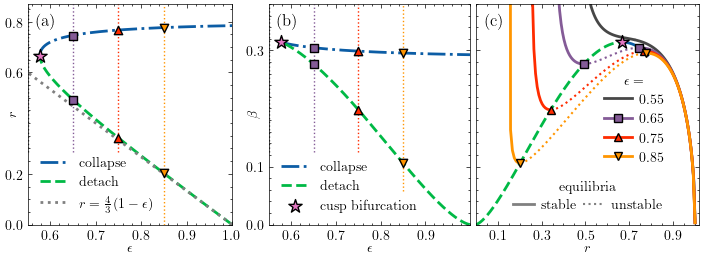

In [ ]:
x_detach_vals = jnp.linspace(0, 2/3, 500)
x_collapse_vals = jnp.linspace(2/3, 0.79, 200)
e_func = lambda x: jnp.sqrt((4 - 3 * x)*(1-x)**2/(4-5*x))
e_detach_vals = e_func(x_detach_vals)
e_collapse_vals = e_func(x_collapse_vals)
h_detach_vals = h_eq(x_detach_vals, eps=e_detach_vals)
h_collapse_vals = h_eq(x_collapse_vals, eps=e_collapse_vals)

# create a figure with two subfigures: left (independent y) and right (contains two axes that share y)
fig = plt.figure(constrained_layout=True, figsize=(7, 2.5))
subfig_left, subfig_right = fig.subfigures(1, 2, width_ratios=[1, 1.9])

ax_ex = subfig_left.subplots()
ax_eh, ax_xh = subfig_right.subplots(1, 2, width_ratios=[0.9, 1.], sharey=True)

ax_ex.plot(e_collapse_vals, x_collapse_vals, label="collapse", ls="-.")
ax_eh.plot(e_collapse_vals, h_collapse_vals, label="collapse", ls="-.")
ax_xh.plot(x_collapse_vals, h_collapse_vals, ls="-.")
ax_ex.plot(e_detach_vals, x_detach_vals, label="detach", ls="--")
ax_eh.plot(e_detach_vals, h_detach_vals, label="detach", ls="--")
ax_xh.plot(x_detach_vals, h_detach_vals, ls="--")

asympt, = ax_ex.plot([1,  0.25], [0,1], linestyle=':', color='gray', lw=2, label=r"$r= \frac{4}{3} (1 -  \epsilon)$")
legend1 = ax_ex.legend(loc=3)

for e_val, marker, color in zip(jnp.linspace(0.55,0.85,4), ['d', 's', '^', 'v'], np.flip(['C2', 'C3', 'C4', 'C5'])):
    res = plot_bif(ax_xh, ax_eh, ax_ex,  e_val, c_line=color, mark=marker)

# ax[0].legend(handles=bifs, loc='upper center', bbox_to_anchor=(0.55,1), handlelength=1, frameon=True, title="bifurcations \n" + r"$\frac{\ell_{1,max}}{\ell_1}$, $\frac{x_{23}}{\ell_1}$", framealpha=1, edgecolor='w', alignment='right')
# ax[0].add_artist(legend1)


dummyhandles = [
    mlines.Line2D([], [], linestyle='-', color='gray', label="stable"),
    mlines.Line2D([], [], linestyle=':', color='gray', lw=1.5, label="unstable")
]

legend2 = ax_xh.legend(loc=(0.55, 0.25), title=r"$\epsilon =$", ncols=1, handletextpad=0.5, columnspacing=0.5, alignment='center')
legend3 = ax_xh.legend(handles=dummyhandles, alignment='center', title="equilibria", loc=8, ncols=2, handletextpad=0.5, columnspacing=0.5, handlelength=1.5)
ax_xh.add_artist(legend2)



ax_eh.legend()

for i, axi in enumerate((ax_ex, ax_eh, ax_xh)):
    c = chr(ord('a') + i)
    axi.set_title(f'({c})', y=1, x = 0.04, pad=-15, loc='left')

ax_ex.scatter(1./jnp.sqrt(3), 2/3, marker='*', s=100, c='C7', edgecolor='k', zorder=5)
ax_eh.scatter(1/(jnp.sqrt(3)), jnp.sqrt(8/81), marker='*', s=100, c='C7', edgecolor='k', zorder=5, label="cusp bifurcation")
ax_xh.scatter(2/3, jnp.sqrt(8/81), marker='*', s=100, c='C7', edgecolor='k', zorder=5)

ax_eh.legend(loc=3)
ax_ex.set_xbound(0.55, 1) 
ax_eh.set_xbound(0.55, 1)
ax_xh.set_xbound(0.0,1.02)
 
ax_ex.set_ybound(0,0.87) 
ax_eh.set_ybound(0, 0.38)
ax_xh.set_ybound(0, 0.38)

ax_xh.set_xlabel(r"$r$", labelpad=0)
ax_ex.set_xlabel(r"$\epsilon$", labelpad=0)
ax_eh.set_xlabel(r"$\epsilon$", labelpad=0)

ax_xh.set_xticks(np.linspace(0.1, 0.9, 5))
ax_eh.set_xticks(np.linspace(0.6, 0.9, 4))
ax_ex.set_xticks(np.linspace(0.6, 1., 5))
ax_ex.set_ylabel(r"$r$", labelpad=-10)
ax_eh.set_ylabel(r"$\beta$", labelpad=-10)

ax_ex.set_yticks([0, 0.2, 0.6, 0.8])
ax_eh.set_yticks([0, 0.1, 0.3])
# ax_xh.set_ylabel(r"$\beta$", labelpad=0)

fig.get_layout_engine().set(w_pad=2/72, h_pad=0, hspace=0, wspace=0)

# plt.savefig('latex/figures/extens_bif.eps', bbox_inches='tight')

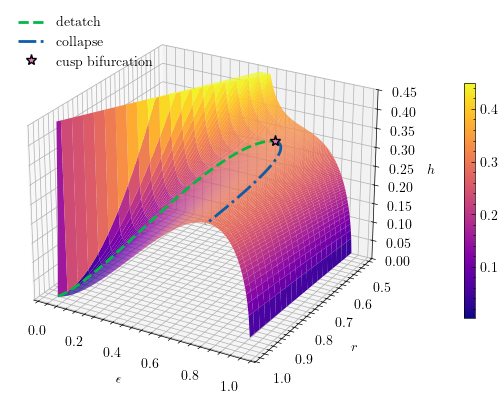

In [ ]:
# 3D surface of h(x, eps) and line of local extrema
E = jnp.linspace(0.5, 1., 100)
X_rel = jnp.linspace(1e-3, 1-1e-8, 150)

X_rel_mesh, E_mesh = np.meshgrid(X_rel, E)   # H shape: (len(X), len(E))
X_mesh = 1 - X_rel_mesh * E_mesh
H = jnp.clip(h_eq(X_mesh, eps=E_mesh), 0, 0.45)

fig3 = plt.figure(figsize=(7, 4))
ax3 = fig3.add_subplot(111, projection='3d')
surf = ax3.plot_surface(X_mesh, E_mesh, H, cmap='plasma', edgecolor='none', alpha=1., rcount=20, ccount=150)

# plot the extrema line
x_vals = jnp.linspace(1e-10, 2/3, 500)
e_vals = jnp.sqrt((3 * x_vals - 4)*(1-x_vals)**2/(5*x_vals -4))
h_vals = h_eq(x_vals, eps=e_vals)

ax3.plot(x_vals, e_vals, h_vals, color='C1', lw=2, label='detach', ls='--', zorder=5)

x_vals = jnp.linspace(2/3, 0.785, 500)
e_vals = jnp.sqrt((3 * x_vals - 4)*(1-x_vals)**2/(5*x_vals -4))
h_vals = h_eq(x_vals, eps=e_vals)

ax3.plot(x_vals, e_vals, h_vals, color='C0', lw=2, label="collapse", ls='-.', zorder=5)
ax3.plot(2./3, 1/jnp.sqrt(3), jnp.sqrt(8./81), color='C7', marker='*', ls='', markersize=8, zorder=100, label='cusp bifurcation', markeredgecolor='k')

ax3.set_xlabel(r'$\epsilon$')
ax3.set_ylabel(r'$r$')
ax3.set_zlabel(r'$h$')
ax3.set_zbound(0, 0.45)
ax3.yaxis.set_inverted(True)
ax3.view_init(elev=25, azim=-60)
ax3.legend() #(loc='lower left', frameon=True, framealpha=0.7)
fig3.colorbar(surf, ax=ax3, shrink=0.6, pad=0.08)
# plt.tight_layout()

# plt.savefig('latex/figures/extens_bif_3d.pdf')


## Phase space curvature and loops

In [8]:
def get_vector_field_and_curvature(order=6):
    def mobility_matrix(x12: float, x23: float, order=order):
        x13 = x12 + x23
        
        M12 = 1.5 / x12
        M13 = 1.5 / x13
        M23 = 1.5 / x23
        M11 = 1
        M22 = 1
        M33 = 1

        if order >= 3:
            M12 -= x12 ** (-3)
            M13 -= x13 ** (-3)
            M23 -= x23 ** (-3)

        if order >= 4:
            M12 -= 3.75 * (x13 ** (-2) * x23 ** (-2))
            M13 += 3.75 * (x12 ** (-2) * x23 ** (-2))
            M23 -= 3.75 * (x12 ** (-2) * x13 ** (-2))
            M11 -= 3.75 * (x12 ** (-4) + x13 ** (-4))
            M22 -= 3.75 * (x12 ** (-4) + x23 ** (-4))
            M33 -= 3.75 * (x13 ** (-4) + x23 ** (-4))

        if order >= 6:
            M12 += 6 * x13 ** (-2) * x23 ** (-2) * (x13 ** (-2) + x23 ** (-2)) - 6.5 * x13 ** (-3) * x23 ** (-3)
            M13 += - 6 * x12 ** (-2) * x23 ** (-2) * (x12 ** (-2) + x23 ** (-2)) - 6.5 * x12 ** (-3) * x23 ** (-3)
            M23 += 6 * x12 ** (-2) * x13 ** (-2) * (x12 ** (-2) + x13 ** (-2)) - 6.5 * x12 ** (-3) * x13 ** (-3)
            M11 += 5.5 * (x12 ** (-6) + x13 ** (-6))
            M22 += 5.5 * (x12 ** (-6) + x23 ** (-6))
            M33 += 5.5 * (x13 ** (-6) + x23 ** (-6))

        return jnp.array([[M11, M12, M13],
                        [M12, M22, M23],
                        [M13, M23, M33]])

    U = jnp.array([[-1.0, 1.0, 0.0], 
                [0.0, -1.0, 1.0],
                [0.0, 1.0, 0.0]])

    @jax.jit
    def vector_field(s):
        x12, x23 = s
        M = mobility_matrix(x12, x23, order=order)
        e = jnp.array([1.0, 1.0, 1.0])
        alpha = jnp.linalg.solve((U @ M).T, e)
        return jnp.array([- alpha[0]/alpha[2], -alpha[1]/alpha[2]])

    @jax.jit
    def curvature(x12, x23):
        jac = jax.jacfwd(vector_field)((x12, x23))
        return jac[0][1] - jac[1][0]
    
    return vector_field, curvature

def get_curvature_mesh(x12, x23, order=6):
    _, curvature = get_vector_field_and_curvature(order=order)
    return jax.vmap(jax.vmap(curvature, in_axes=(None, 0)), in_axes=(0, None))(x12, x23)

### approximation error

In [9]:

x12 = jnp.linspace(2.8, 25.0, 100)
x23 = jnp.linspace(2.8, 25.0, 100)
x12_grid, x23_grid = jnp.meshgrid(x12, x23, indexing='ij')

z6 = jnp.log(jnp.abs(get_curvature_mesh(x12, x23, order=6)))
z4 = jnp.log(jnp.abs(get_curvature_mesh(x12, x23, order=4)))
z3 = jnp.log(jnp.abs(get_curvature_mesh(x12, x23, order=3)))
z1 = jnp.log(jnp.abs(get_curvature_mesh(x12, x23, order=2)))
z_leading = jnp.log(jnp.abs(1/3 * (x12_grid**(-2) + x23_grid**(-2) - (x12_grid + x23_grid)**(-2))))


In [10]:
def plot_difference(z1, z2, v_max=None, ticks2=[0, 0.2, 0.8, 1., 1.2]):
    vmin = z1.min() # float(jnp.minimum(z1.min(), z2.min()))
    vmax = z1.max() #float(jnp.maximum(z1.max(), z2.max()))

    # Create two subplots sharing both axes
    fig, axes = plt.subplots(1, 3, figsize=(6.8, 2.3), constrained_layout=True, sharey=True)

    # First contourf
    cf1 = axes[0].contourf(x12_grid, x23_grid, z1, levels=20, cmap="viridis", vmin=vmin, vmax=vmax)
    # axes[0].set_title(title1)
    # Second contourf
    cf2 = axes[1].contourf(x12_grid, x23_grid, z2, levels=20, cmap="viridis", vmin=vmin, vmax=vmax)
    # axes[1].set_title(title2)

    # Shared colorbar — note: pass all contour sets as mappables
    cb1 = fig.colorbar(cf1, ax=axes[1], orientation="vertical", fraction=0.05, pad=0.0, ticks=[-7, -6, -4, -3])
    cb1.set_label(r"$\ln f$", labelpad=-6)


    # Third contourf: difference
    if v_max is None:
        v_max = jnp.max(jnp.abs(z1 - z2))
    cf3 = axes[2].contourf(x12_grid, x23_grid, z2 - z1, levels=50, cmap="RdBu_r", vmin=-v_max, vmax=v_max)
    cb2 = fig.colorbar(cf3, ax=axes[2], orientation="vertical", fraction=0.05, pad=0.0, ticks=ticks2)
    cb2.set_label(r"$\Delta \ln f$", labelpad=-10)


    axes[0].set_ylabel(r"$x_{23}$", labelpad=-6)
    for i, (ax, col) in enumerate(zip(axes, ['k', 'k', 'k'])):
        ax.set_xlabel(r"$x_{12}$", labelpad=-6)
        ax.set_aspect('equal')
        ax.set_xticks([5, 10, 20, 25])
        ax.set_yticks([5, 10, 20, 25])
        c = chr(ord('a') + i)
        ax.set_title(fr"\textbf{{({c})}}", y=1, x = 0.04, pad=-15, loc='left', color=col)

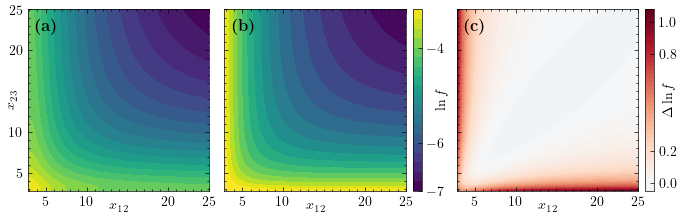

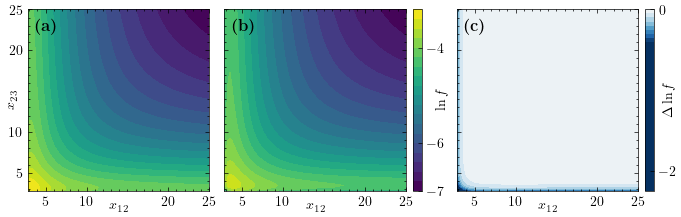

In [224]:
plot_difference(z6, z_leading, v_max=None, ticks2=[0, 0.2, 0.8, 1.])
plt.savefig('latex/figures/curvature_approximation_error_o6_farfield_wide.eps', bbox_inches='tight')
plot_difference(z6, z4, v_max=0.4, ticks2=[-2.0, 0.])
plt.savefig('latex/figures/curvature_approximation_error_o6_o4_wide.eps', bbox_inches='tight')


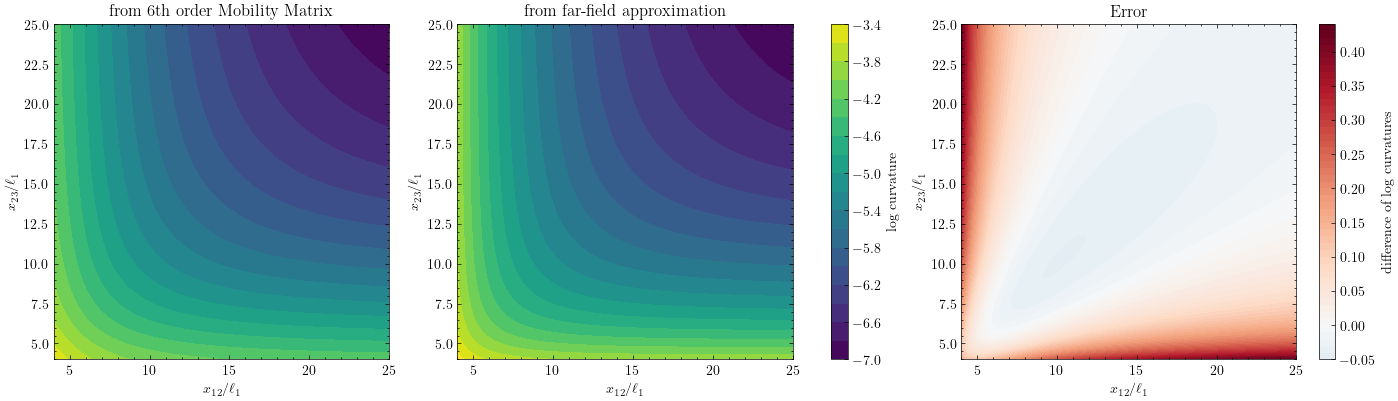

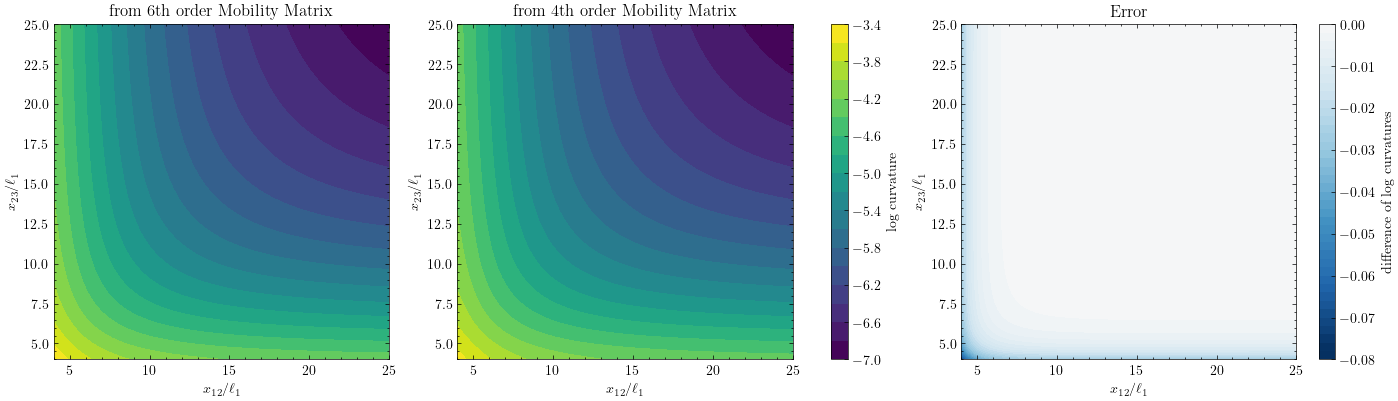

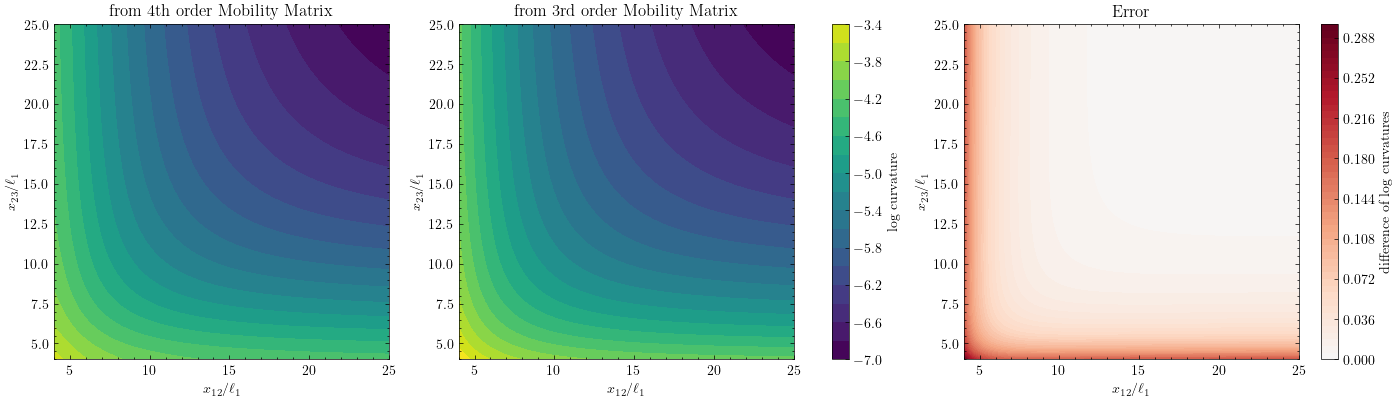

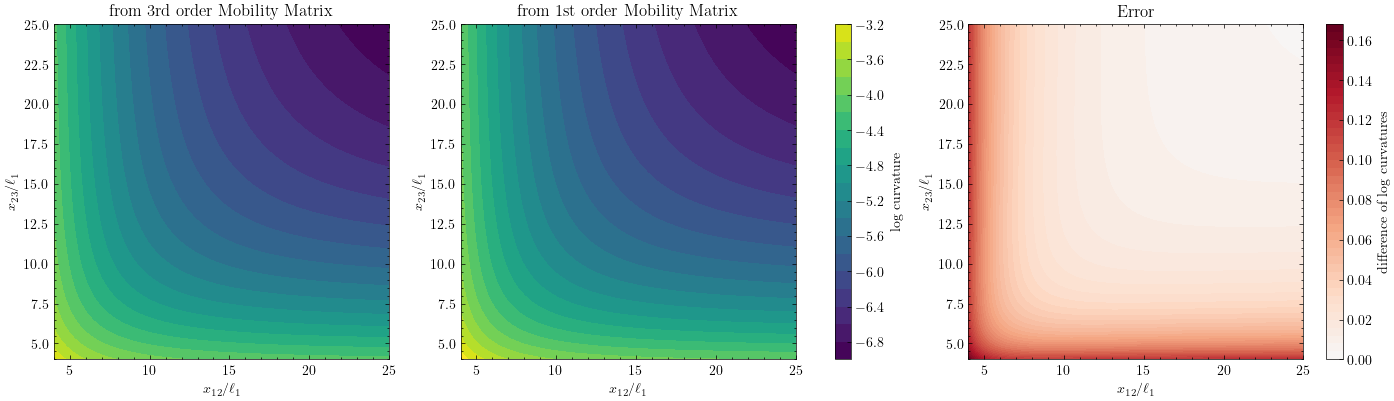

In [8]:
plot_difference(z6, z_leading, title1='from 6th order Mobility Matrix', title2='from far-field approximation')
plt.savefig('latex/figures/curvature_approximation_error_leading_lmin4.eps', bbox_inches='tight')
plot_difference(z6, z4, title1='from 6th order Mobility Matrix', title2='from 4th order Mobility Matrix')
plt.savefig('latex/figures/curvature_approximation_error_6th_4th_lmin4.eps', bbox_inches='tight')
plot_difference(z4, z3, title1='from 4th order Mobility Matrix', title2='from 3rd order Mobility Matrix')
plt.savefig('latex/figures/curvature_approximation_error_4th_3rd_lmin4.eps', bbox_inches='tight')
plot_difference(z3, z1, title1='from 3rd order Mobility Matrix', title2='from 1st order Mobility Matrix')
plt.savefig('latex/figures/curvature_approximation_error_3rd_1st_lmin4.eps', bbox_inches='tight')

### phase space and configuration space loops

In [11]:
l_res = 512
c_res = 512
dbdt=1e-3
grid_filename = f"data/velocity_grid_dbdt_1e3_l2_25_c2_10_lmin_4_lr_{l_res}_cr_{c_res}.csv"
samples = [(0.9,0.4), (0.9, 0.9), (0.4, 0.9)]
markers = ['o', 'd', '^']
colors = ['C2', 'C3', 'C7']
linestyles = ['--', ':', '-.']
df = pd.read_csv(grid_filename, index_col=0)

V = df.values.astype(float)
l_ratio = jnp.array(df.index, dtype=float)
c_ratio = jnp.array(df.columns, dtype=float)


x12 = jnp.arange(2.5, 25.0, 0.2)
x23 = jnp.arange(2.5, 30.0, 0.2)
log_curv = jnp.log(jnp.abs(get_curvature_mesh(x12, x23, order=6))).T

/tmp/ipykernel_26221/2695280297.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('latex/figures/phase_and_config_space.pdf', bbox_inches='tight')


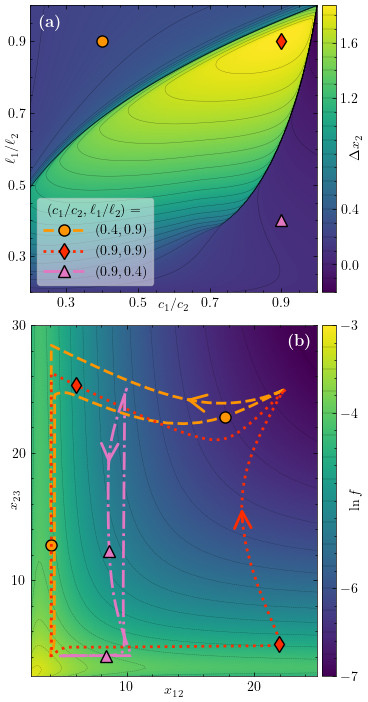

In [13]:
fig, (ax_phase, ax_config) = plt.subplots(2, figsize=(3.4,7), height_ratios=[3.15,3.85])

PC = ax_phase.pcolormesh(c_ratio, l_ratio, V*2/dbdt, shading='gouraud', cmap='viridis', vmin=-0.2, rasterized=True)
CF = ax_phase.contour(c_ratio, l_ratio, V*2/dbdt, levels=jnp.linspace(-0.2, 1.8, 21), colors='k', linewidths=0.3, alpha=0.4)

divider = make_axes_locatable(ax_phase)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(PC, cax=cax, ticks=[0, 0.4, 1.2, 1.6])
cbar.add_lines(CF)
cbar.set_label(r'$\Delta x_2$', labelpad=-6)
ax_phase.set_aspect('equal')


vmin = -7
vmax = -3
levels = jnp.linspace(vmin, vmax, 17)
PC = ax_config.pcolormesh(x12, x23, log_curv, shading='gouraud', cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True)
CF = ax_config.contour(x12, x23, log_curv, levels=levels, colors='k', linewidths=0.3, alpha=0.4)

divider = make_axes_locatable(ax_config)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(PC, cax=cax, ticks=[-7, -6, -4, -3])
cbar.set_label(r"$\ln f$", labelpad=-6)
cbar.add_lines(CF)
ax_config.set_aspect('equal')

handles = []
if samples is not None and len(samples) > 0:
    for ((lr, cr), color, shape, ls, lf, r) in zip(samples, colors, markers, linestyles, [0.72, 0.6, 0.87], [102, 175, 400]):
        scat = ax_phase.plot([cr], [lr], color=color, marker=shape, markeredgecolor='k', ls=ls, markersize=8, label=rf"$({cr:.1f}, {lr:.1f})$")
        df = pd.read_csv(f'data/trajectory_dbdt_1e3_l2_25_c2_10_lmin_4_lr_{lr:.1f}_cr_{cr:.1f}.csv')
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        df = pd.DataFrame(data=np.roll(df, r, axis=0), columns=df.columns)
        df = pd.concat([df, df.iloc[0]], ignore_index=True)
        p = 3
        loop = ax_config.plot((df['x2'] - df['x1'])[::p], (df['x3'] - df['x2'])[::p], color=color, marker=shape, markevery=1.2, markersize=8, markeredgecolor='k', ls=ls)
        add_arrow(loop[0], i="", ho=0.3, vo=-0.3, size=30, color=color, length_fraction=lf)
            
ax_phase.set_xlabel(r'$c_1/c_2$', labelpad=-8)
ax_phase.set_xticks([0.3, 0.5, 0.7, 0.9])
ax_phase.set_ylabel(r'$\ell_1/\ell_2$', labelpad=-8)
ax_phase.set_yticks([0.3, 0.5, 0.7, 0.9])

ax_config.set_xlabel(r'$x_{12}$', labelpad=-6)
ax_config.set_xticks(jnp.arange(10, 25, 10))
ax_config.set_ylabel(r'$x_{23}$', labelpad=-6)
ax_config.set_yticks(jnp.arange(10, 31, 10))

ax_phase.set_title(r'\textbf{(a)}', y=1, x = 0.03, pad=-15, loc='left', color='white', fontweight='bold')
ax_config.set_title(r'\textbf{(b)}', y=1, x = 0.9, pad=-15, loc='left', color='white', fontweight='bold')

ax_phase.legend(frameon=True, title=r'$(c_1/c_2, \ell_1/\ell_2) =$', handlelength=3, framealpha=0.5)

plt.savefig('latex/figures/phase_and_config_space.pdf', bbox_inches='tight')

### test of configuration space integral

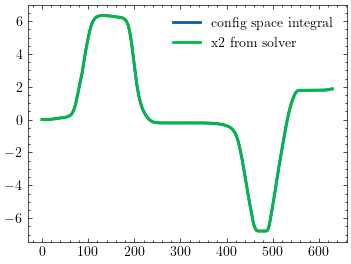

In [ ]:
lr, cr = samples[1]
df = pd.read_csv(f'data/trajectory_dbdt_1e3_l2_25_c2_10_lmin_4_lr_{lr:.1f}_cr_{cr:.1f}.csv')
df = df.replace([np.inf, -np.inf], np.nan).dropna()
v, _ = get_vector_field_and_curvature(order=7)
s = jnp.stack((jnp.array(df['x2'] - df['x1']), jnp.array(df['x3'] - df['x2']))).T
vec = jax.vmap(v)(s)
vec = (vec[1:, :] + vec[:-1, :]) * 0.5
ds = jnp.diff(s, axis=0)
t = df['t'].values[1:]
plt.plot(jnp.cumsum(jnp.sum(vec*ds, axis=1)), label='config space integral')
plt.plot(jnp.cumsum(jnp.diff(jnp.array(df['x2']),1)), ls='--', label='x2 from solver')
plt.legend()

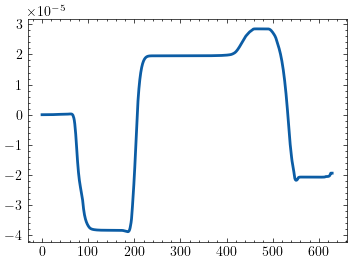

In [12]:
plt.plot(jnp.cumsum(jnp.sum(vec*ds, axis=1)) - jnp.cumsum(jnp.diff(jnp.array(df['x2']),1)), label='x2 from solver')

## Trajectories

#### Cos

0.7913287739887453


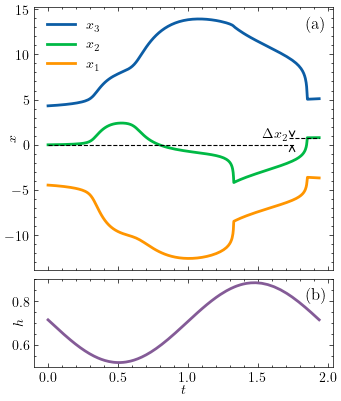

In [2]:
fig, (ax, axb) = plt.subplots(2, figsize=(3.4, 4), height_ratios=[3, 1], sharex=True)
ax.set_ylabel(r'$x$', labelpad=-10)
axb.set_ylabel(r'$h$', labelpad=-10)
axb.set_xlabel(r'$t$', labelpad=0)

df = pd.read_csv('data/trajectory_cos_opt.csv')
df = df.replace(jnp.inf, jnp.nan).dropna()
ax.plot(df['t'], df['x3'], label=r'$x_3$')
ax.plot(df['t'], df['x2'], label=r'$x_2$')
ax.plot(df['t'], df['x1'], label=r'$x_1$')
ax.legend(frameon=False)
axb.plot(df['t'], df['h'], label=r'$h$', color='C4')
x0 = 0.
x1 = float(df['x2'].iloc[-1])
t_end = float(df['t'].iloc[-1])
t_arrow = 0.9 * t_end
ax.plot([0, t_arrow+0.02], [x0, x0], color='k', ls='--', lw=0.8)
ax.plot([t_arrow-0.02, t_end], [x1, x1], color='k', ls='--', lw=0.8)

# small offset for the short arrows
arrow_offset = 0.6

# short arrow above the top line pointing down
ax.annotate('',
            xy=(t_arrow, x1), xytext=(t_arrow, x1 + arrow_offset),
            arrowprops=dict(arrowstyle='->', color='k', lw=0.8))

# short arrow below the bottom line pointing up
ax.annotate('',
            xy=(t_arrow, x0), xytext=(t_arrow, x0 - arrow_offset),
            arrowprops=dict(arrowstyle='->', color='k', lw=0.8))

ax.text(t_arrow - 0.04, 0.5 * (x0 + x1), r'$\Delta x_2$', va='bottom', ha='right')

for i, axi in enumerate((ax, axb)):
    c = chr(ord('a') + i)
    axi.set_title(f'({c})', y=1, x = 0.91, pad=-15, loc='left')

plt.savefig('latex/figures/optimal_cos_cycle.png', bbox_inches='tight', dpi=300)
print(x1 - x0)

#### Bang Bang

0.7691113973141924


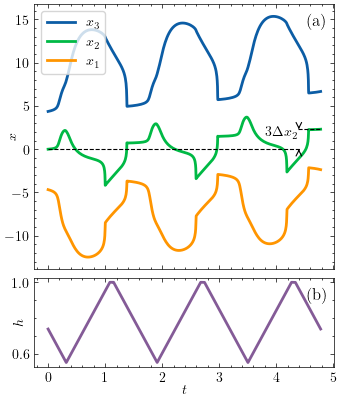

In [112]:
fig, (ax, axb) = plt.subplots(2, figsize=(3.4, 4), height_ratios=[3, 1], sharex=True)
ax.set_ylabel(r'$x$', labelpad=-10)
axb.set_ylabel(r'$h$', labelpad=-10)
axb.set_xlabel(r'$t$', labelpad=0)
axb.set_yticks([0.6, 1.])

df = pd.read_csv('data/trajectory_bang_bang_opt.csv')
df = df.replace(jnp.inf, jnp.nan).dropna()
ax.plot(df['t'], df['x3'], label=r'$x_3$')
ax.plot(df['t'], df['x2'], label=r'$x_2$')
ax.plot(df['t'], df['x1'], label=r'$x_1$')
ax.legend(frameon=True, framealpha=0.8)
axb.plot(df['t'], df['h'], label=r'$h$', color='C4')
x0 = 0.
x1 = float(df['x2'].iloc[-1])
t_end = float(df['t'].iloc[-1])
t_arrow = 0.92 * t_end
ax.plot([0, t_arrow+0.02], [x0, x0], color='k', ls='--', lw=0.8)
ax.plot([t_arrow-0.02, t_end], [x1, x1], color='k', ls='--', lw=0.8)

# small offset for the short arrows
arrow_offset = 0.6

# short arrow above the top line pointing down
ax.annotate('',
            xy=(t_arrow, x1), xytext=(t_arrow, x1 + arrow_offset),
            arrowprops=dict(arrowstyle='->', color='k', lw=0.8))

# short arrow below the bottom line pointing up
ax.annotate('',
            xy=(t_arrow, x0), xytext=(t_arrow, x0 - arrow_offset),
            arrowprops=dict(arrowstyle='->', color='k', lw=0.8))

ax.text(t_arrow - 0.04, 0.5 * (x0 + x1), r'$3\Delta x_2$', va='bottom', ha='right')

for i, axi in enumerate((ax, axb)):
    c = chr(ord('a') + i)
    axi.set_title(f'({c})', y=1, x = 0.91, pad=-15, loc='left')

# plt.savefig('latex/figures/optimal_bang_bang_cycle.eps', bbox_inches='tight', dpi=300)
print((x1 - x0)/3)

#### Config Space

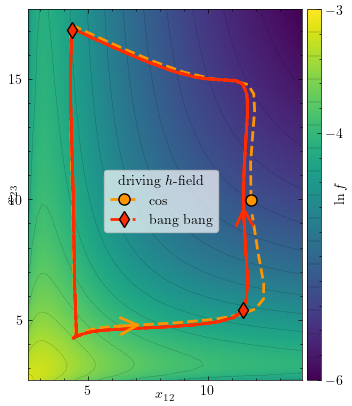

In [139]:
fig, ax_config = plt.subplots(1, figsize=(3.4,4))


x12 = jnp.arange(2.5, 14.0, 0.2)
x23 = jnp.arange(2.5, 18.0, 0.2)
log_curv = jnp.log(jnp.abs(get_curvature_mesh(x12, x23, order=6))).T

vmin = -6
vmax = -3
levels = jnp.linspace(vmin, vmax, 17)
PC = ax_config.pcolormesh(x12, x23, log_curv, shading='gouraud', cmap='viridis', vmin=vmin, vmax=vmax, rasterized=True)
CF = ax_config.contour(x12, x23, log_curv, levels=levels, colors='k', linewidths=0.3, alpha=0.4)

divider = make_axes_locatable(ax_config)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(PC, cax=cax, ticks=[-7, -6, -4, -3])
cbar.set_label(r"$\ln f$", labelpad=-6)
cbar.add_lines(CF)
ax_config.set_aspect('equal')

colors = ['C2', 'C3']
markers = ['o', 'd']
linestyles = ['--', '-.']
handles = []
for (name, color, shape, ls, lf, r) in zip(['cos', 'bang_bang'], colors, markers, linestyles, [0.83, 0.58], [300, 100]):
    df = pd.read_csv(f'data/trajectory_{name}_opt.csv')
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df = pd.DataFrame(data=np.roll(df, r, axis=0), columns=df.columns)
    df = pd.concat([df, df.iloc[0]], ignore_index=True)
    p = 3
    loop = ax_config.plot((df['x2'] - df['x1'])[::p], (df['x3'] - df['x2'])[::p], color=color, marker=shape, markevery=3., markersize=8, markeredgecolor='k', ls=ls, label=rf"{name.replace('_', ' ')}")
    add_arrow(loop[0], i="", ho=0.3, vo=-0.3, size=30, color=color, length_fraction=lf)

ax_config.set_xlabel(r'$x_{12}$', labelpad=-6)
ax_config.set_xticks(jnp.arange(5, 12, 5))
ax_config.set_ylabel(r'$x_{23}$', labelpad=-6)
ax_config.set_yticks(jnp.arange(5, 16, 5))
ax_config.legend(frameon=True, loc=(0.28,0.4), framealpha=0.7, title=r"driving $h$-field")

plt.savefig('latex/figures/config_space_opt.pdf', bbox_inches='tight')

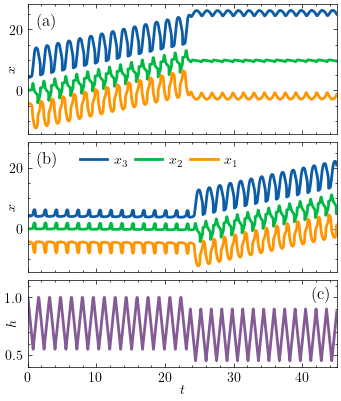

In [144]:
fig, (ax1, ax2, axb) = plt.subplots(3, figsize=(3.4, 4), height_ratios=[1.5, 1.5, 1], sharex=True)
ax1.set_ylabel(r'$x$', labelpad=-6)
ax2.set_ylabel(r'$x$', labelpad=-6)
axb.set_ylabel(r'$h$', labelpad=-10)
axb.set_xlabel(r'$t$', labelpad=0)
axb.set_yticks([0.5, 1.])

for i, ax in enumerate((ax1, ax2)):
    df = pd.read_csv(f'data/trajectory_individual_control_{i + 1}.csv')
    df = df.replace(jnp.inf, jnp.nan).dropna()
    ax.plot(df['t'], df['x3'], label=r'$x_3$')
    ax.plot(df['t'], df['x2'], label=r'$x_2$')
    ax.plot(df['t'], df['x1'], label=r'$x_1$')
    c = chr(ord('a') + i)
    ax.set_title(f'({c})', y=1, x = 0.03, pad=-15, loc='left')
    # ax.legend(frameon=True, framealpha=0.8)

ax2.legend(ncol=3, loc=(0.15,0.77), columnspacing=0.5, handletextpad=0.5)
axb.plot(df['t'], df['h'], label=r'$h$', color='C4')

axb.set_title('(c)', y=1, x = 0.92, pad=-13, loc='left')
axb.set_xlim(0, 45)
axb.set_ylim(0.4, 1.15)

# plt.savefig('latex/figures/individual_control.eps', bbox_inches='tight', dpi=300)